This file is to try Nexis-SBI

Note that, the original Nexis params are bounded, so I transform them first (to real line). 

The simulator fn in our case requires trans-params not the org params. 
I put a guassian prior on the trans-params. 
So the SBI gives the posterior sps of the trans-params, I transform them back to the original params.



### import and define

In [1]:
import sys
sys.path.append("../mypkg")
import mkl

#### Other pkgs

In [2]:
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

#### My own pkgs

In [3]:
import importlib

from utils.misc import save_pkl_dict2folder, load_pkl_folder2dict
from utils.reparam import para_trans2org, logistic_np, logistic_torch
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
import from_justin.nexis as nx

In [4]:
# # load the data and build the nexis model
# loadinst = nx.loading_matfiles()
# endmstuff = loadinst.load_file('eNDM_mousedata.mat')
# # the following are required for build a model
# C = endmstuff['Networks'][0,0]['ret']
# C = C / np.max(C[:])
# endmstuff_kauf = loadinst.load_file('KaufmanDiamond_datasets_dat&seed.mat')
# seedvec = endmstuff_kauf['seed426'][0,0]['DS6']
# tpts = endmstuff_kauf['tpts'][0,0]['DS6'][0]
# U = np.zeros([426,1]);

# # the model for generate
# nexis_model = nx.run_Nexis(C, U, seedvec, tpts)

# # real data, the real data decide the nan positions and decide the simulator function
# data = endmstuff_kauf['data426'][0,0]['DS6'];

In [5]:
# np.shape(seedvec)

### Load data 

In [6]:
# load the data and build the nexis model
loadinst = nx.loading_matfiles()
studyname = 'DS6'
# load the connectome and normalize
C = loadinst.load_file('Connectomes.mat')
C = C['Connectomes'][0,0]['default']
C = C / np.max(C[:])
# load the data
endmstuff = loadinst.load_file('Mouse_Tauopathy_Data_HigherQ_CCF.mat')
data = endmstuff['mousedata_struct_ccf'][0,0][studyname][0]['data'][0]
seedvec = endmstuff['mousedata_struct_ccf'][0,0][studyname][0]['seed'][0]
tpts = endmstuff['mousedata_struct_ccf'][0,0][studyname][0]['time_stamps'][0]
tpts = np.ndarray.flatten(tpts)
U = np.zeros([426,1]); # cell type or gene expression vector/matrix

# the model for generate
nexis_model = nx.run_Nexis(C, U, seedvec, tpts, w_dir_ = 1, volcorrect_ = 1) # Keep same

#### Set up Parameters

In [7]:
# some constant parameters for this file
# typically not change
paras_ = edict()
paras_.n_types = U.shape[1]
# same order to the function
paras_.par_low = np.array([0, 0, 0, 0, -5, -5]) # Keep same
# maybe play around with this one, lower paras_.par_high[1] to 3 and lower paras_.par_high[2] to 5(?)
paras_.par_high = np.array([1, 5, 10, 1, 5, 5]) 
paras_.bds = np.array([paras_.par_low, paras_.par_high]).T
paras_.names = ["alpha", "beta", "gamma", "s", "b", "p"]
# the parameter for var transfomration
# take the length of b and p into account
paras_.bds_full = np.concatenate([paras_.bds[:-2], 
    np.repeat(paras_.bds[-2].reshape(1, -1), paras_.n_types, axis=0),
    np.repeat(paras_.bds[-1].reshape(1, -1), paras_.n_types, axis=0),
    ])
paras_.k = 0.1 # Keep same

# convert the trans-param back to the org params
_para_trans2org = partial(para_trans2org, 
                          map_fn=partial(logistic_np, k=paras_.k))

# Some hyperparams, tuning them for better results
paras = edict()
# the std of noise added to the simulated data, now my formula is simu_data * (1+noise)
# You may want to tune it. Larger one, smoother of the posterior.
paras.noise_sd = 0.5 # CHANGE THIS ONE: range [0,2] (maybe linear from 0 to 2, 0.2 step size)
# The num of simulated sps used for training the model, 1e3 is too small, make it larger. 
# The larger, the better, but you also have to consider the computational burden.
paras.num_prior_sps = int(1000) # CHANGE THIS ONE: range [1e4,2e5] (pick a few: 10000,50000,100000,200000)
# The density estimator. 
# Without solid reason, do not change it 
paras.den_est = "nsf" # Keep same
# The std of prior of the parameters
# Without solid reason, do not change it 
# If you change it, you have to also adjust paras_.k
paras.prior_sd = 10 # Keep same

In [8]:
# save the results
_folder_path = f"./nexis_num{paras.num_prior_sps:.0f}" +\
               f"_sd{paras.noise_sd*100:.0f}" +\
               f"_denest{paras.den_est}"
paras.folder_path = RES_ROOT/_folder_path
print(f"folder is {paras.folder_path}")
if not paras.folder_path.exists():
    paras.folder_path.mkdir()

folder is /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf


### Prepare for SBI

In [9]:
# The main fn in SBI, simulate the data
def simulator(para_trans, noise_sd, data):
    """I add noise by multiplying"""
    para_org = _para_trans2org(para_trans, paras_.bds_full)
    res = nexis_model.simulate_nexis(para_org);
    # remove the part of simu-data corresponding to the nan in the real data
    nonnan_idxs = ~np.isnan(data.sum(axis=1));
    res = res[nonnan_idxs]
    noise = np.random.randn(*res.shape)*noise_sd + 1
    return res * noise 

In [10]:
# The prior dist to generate the simulated data
prior = MultivariateNormal(loc=torch.zeros(paras_.bds_full.shape[0]), 
                           covariance_matrix=torch.eye(paras_.bds_full.shape[0])*(paras.prior_sd**2))

### SBI

In [11]:
simulator_sp = partial(simulator,  noise_sd=paras.noise_sd, data=data)
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)

#### RUN

In [12]:
# generate the simulated sps
params, x = simulate_for_sbi(simulator_wrapper, prior, 
                            num_simulations=int(paras.num_prior_sps), 
                            num_workers=10); # Don't change

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:26<?, ?it/s]

/data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/utils/reparam.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  res[np.isinf(num)] = 1
/data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/utils/reparam.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  res[np.isinf(num)] = 1
/data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/utils/reparam.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  res[np.isinf(nu

In [14]:
# training and get the posterior
inference = SNPE(prior=prior, density_estimator=paras.den_est)
density_estimator = inference.append_simulations(params, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 74 epochs.

In [15]:
# save it 
cur_res = edict()
cur_res.params_trans = params
cur_res.x = x
cur_res.posterior = posterior
save_pkl_dict2folder(paras.folder_path, cur_res, is_force=True)

Save to /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/params_trans.pkl
Save to /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/x.pkl
Save to /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/posterior.pkl


### Posterior 

In [16]:
cur_res = load_pkl_folder2dict(paras.folder_path, ["x", "para*"]);

Load file /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/post_sps_org.pkl
Load file /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/post_sps_trans.pkl
Load file /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/posterior.pkl


In [17]:
# just to remove nan
# now my real data has nan, you should find a way to handle the nan
nonnan_idxs = np.isnan(data).sum(axis=1)==0
data_part = data[nonnan_idxs];
cur_x = data_part.flatten();
cur_x = torch.Tensor(cur_x)
post_sps_trans = cur_res.posterior.sample((1000, ),  x=cur_x);

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/post_sps_org.pkl
Save to /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/post_sps_trans.pkl
Save to /data/rajlab1/user_data/lucia/Nexis_SBI/notebooks/../mypkg/../results/nexis_num1000_sd50_denestnsf/posterior.pkl


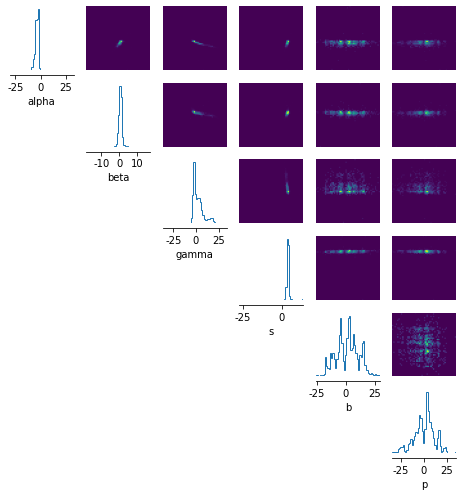

In [18]:
cur_res.post_sps_trans = post_sps_trans
save_pkl_dict2folder(paras.folder_path, cur_res, is_force=True, verbose=True);
_ = analysis.pairplot(cur_res.post_sps_trans,
                      labels=paras_.names, 
                      figsize=(8,8));

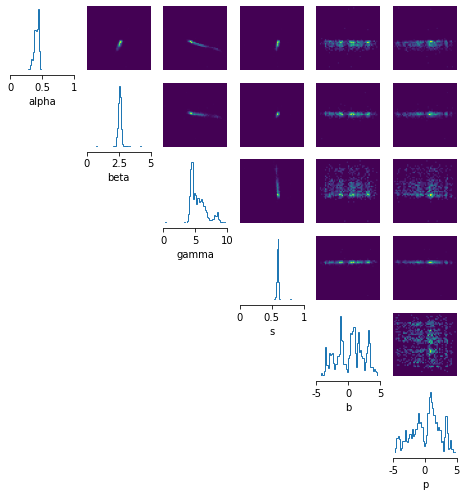

In [19]:
# from trans_data to org data
post_sps_org = _para_trans2org(cur_res.post_sps_trans, paras_.bds_full); # 1000 samples forming the posteriors of the parameters in the original space
cur_res.post_sps_org = post_sps_org
save_pkl_dict2folder(paras.folder_path, cur_res, is_force=True, verbose=False)
_ = analysis.pairplot(cur_res.post_sps_org,
                      limits=paras_.bds_full,
                      labels=paras_.names, 
                      figsize=(8,8));

In [20]:
# Create model from modes of distributions and compare (e.g. Pearson's correlation, scatterplot) with the data

In [21]:
# Tablulate the correspondence between model and data as a function of the parameters that were used
# and the hyperparameters/conditions that were passed to SBI to compare/contrast and find an "optimal"
# way to run

In [22]:
# Query posterior statistics
param_post = np.array(post_sps_org) # Convert to numpy array
postmean = np.mean(param_post,axis = 0) # Take mean over simulations (or whichever statistic you want, e.g. median, mode)

In [23]:
# Test out overall model fit using the mean of the parameters
y = nexis_model.simulate_nexis(postmean) # Run the Nexis model using the best estimate of the parameters
y_part = y[nonnan_idxs] # remove unsampled regions
test = np.shape(y_part)
test = test[0]
y_part_vec = np.reshape(y_part,(test*3,1)) # Flatten all time points of model simulation into a vector
y_part_vec = np.ndarray.flatten(y_part_vec)
data_part_vec = np.reshape(data_part,(test*3,1)) # Flatten all time points of data into a vector
data_part_vec = np.ndarray.flatten(data_part_vec)
np.corrcoef(y_part_vec,data_part_vec) # Calculate R

array([[1.       , 0.5800954],
       [0.5800954, 1.       ]])

In [24]:
# Summary of things to test:
# Prior noise term (bounded between 0 and 2)
# Number of samples to train SBI on (bounded between 1e4 and 2e5)

# Desired outputs (tabular)
# Posterior statistics (mean, median, standard deviation) on the four relevant model parameters
# Fits to data per time point (R or R^2)
# Overall fit to data across time point (R or R^2)
# Scatterplots of best hyperparameter sets

In [25]:
print(np.array([np.mean(y_part_vec,axis=0),np.mean(data_part_vec,axis=0)]))

[2.87217158 0.44163813]
